# Image classifier for the The Street View House Numbers (SVHN) Dataset

In this notebook, you will use a neural network that classifies real-world images digits. You
will use concepts from throughout this course to run different part of model on either CPU or GPU and compare the results.

In [1]:
import tensorflow as tf
import time
from scipy.io import loadmat

In [2]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2022-01-30 15:58:24--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.3’

100%[======================================>] 182,040,794 15.1MB/s   in 16s    

2022-01-30 15:58:41 (10.6 MB/s) - ‘train_32x32.mat.3’ saved [182040794/182040794]

--2022-01-30 15:58:41--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.3’

100%[======================================>] 64,275,384  14.2MB/s   in 9.3s   

2022-01-30 15:58:50 (6.58 MB/s) - ‘test_32x32.mat.3’ saved [642

In [3]:
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

%matplotlib inline

In [5]:
x_train = train['X']/255.
y_train = train['y']

x_test = test['X']/255.
y_test = test['y']

In [6]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

<ipython-input-7-eea9e1d3e61f>:3: DeprecationWarning: This function is deprecated. Please call randint(1, 73257 + 1) instead
  im_set = np.random.random_integers(1, x_train.shape[3], num_plts)


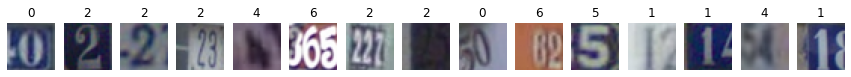

In [7]:
num_plts = 15
fig, ax = plt.subplots(1, num_plts, figsize=(num_plts, 1))
im_set = np.random.random_integers(1, x_train.shape[3], num_plts)

for i in range(len(im_set)):
    ax[i].imshow(x_train[:,:,:,im_set[i]])
    ax[i].axis('off')
    ax[i].set_title(y_train[im_set[i]][0])

plt.show()

In [8]:
x_train_gs = np.mean(x_train, axis = 2, keepdims=True)
x_train_gs = x_train_gs.transpose(3,0,1,2)
x_test_gs = np.mean(x_test, axis = 2, keepdims=True)
x_test_gs = x_test_gs.transpose(3,0,1,2)

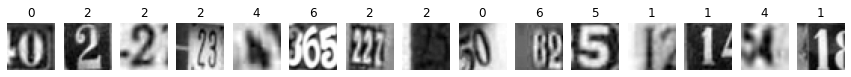

In [9]:
fig, ax = plt.subplots(1, num_plts, figsize=(num_plts, 1))
for i in range(len(im_set)):
    ax[i].imshow(x_train_gs[im_set[i],:,:,0], cmap = 'gray')
    ax[i].axis('off')
    ax[i].set_title(y_train[im_set[i]][0])

plt.show()

### MLP neural network classi

In [10]:
def get_model(input_shape, dropout_rate, nn_units):
    model = Sequential([Flatten(input_shape = input_shape),
                        Dense(nn_units, activation = 'relu', kernel_initializer = 'he_uniform'),
                        Dropout(dropout_rate),
                        Dense(nn_units, activation = 'relu', kernel_initializer = 'he_uniform'),
                        Dropout(dropout_rate),
                        Dense(nn_units, activation = 'relu', kernel_initializer = 'he_uniform'),
                        Dropout(dropout_rate),
                        Dense(nn_units, activation = 'relu', kernel_initializer = 'he_uniform'),
                        Dropout(dropout_rate),
                        Dense(10, activation = 'softmax')])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=["accuracy"])
    
    return model

In [11]:
model_mlp = get_model(x_train_gs.shape[1:4],0,64)

In [12]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [13]:
checkpoint_best_path = 'mlp_chkpnts_bst/chkpnt'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path, save_weights_only=True, monitor='val_accuracy', save_best_only = True, verbose = 1)
earlystop = EarlyStopping(monitor='loss', patience = 5)

In [14]:
epochs = 32
batch_size = 2*64

In [15]:
start = time.time()
history_mlp = model_mlp.fit(x_train_gs, y_train, epochs = epochs, batch_size=batch_size, 
                        validation_split = 0.15, callbacks=[checkpoint_best, earlystop])
endt = time.time()-start
print("Time for {} epochs: {:0.2f}ms".format(epochs,1000*endt))

Epoch 1/32
487/487 [==============================] - 3s 4ms/step - loss: 2.0275 - accuracy: 0.2860 - val_loss: 1.6855 - val_accuracy: 0.4246

Epoch 00001: val_accuracy improved from -inf to 0.42461, saving model to mlp_chkpnts_bst/chkpnt
Epoch 2/32
487/487 [==============================] - 2s 3ms/step - loss: 1.4256 - accuracy: 0.5258 - val_loss: 1.2767 - val_accuracy: 0.5843

Epoch 00002: val_accuracy improved from 0.42461 to 0.58431, saving model to mlp_chkpnts_bst/chkpnt
Epoch 3/32
487/487 [==============================] - 2s 3ms/step - loss: 1.1960 - accuracy: 0.6162 - val_loss: 1.1506 - val_accuracy: 0.6343

Epoch 00003: val_accuracy improved from 0.58431 to 0.63427, saving model to mlp_chkpnts_bst/chkpnt
Epoch 4/32
487/487 [==============================] - 2s 3ms/step - loss: 1.1088 - accuracy: 0.6508 - val_loss: 1.1331 - val_accuracy: 0.6373

Epoch 00004: val_accuracy improved from 0.63427 to 0.63727, saving model to mlp_chkpnts_bst/chkpnt
Epoch 5/32
487/487 [===============

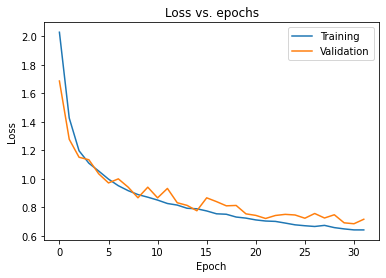

In [16]:
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

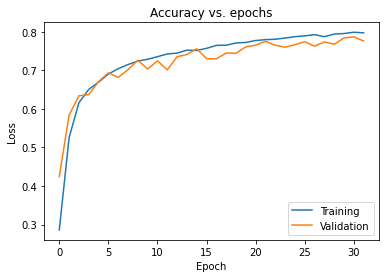

In [17]:
plt.plot(history_mlp.history['accuracy'])
plt.plot(history_mlp.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

### CNN neural network classifier

In [18]:
def get_model_cnn(input_shape, dropout_rate, nn_units):
    model = Sequential([
        Conv2D(8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform', input_shape = input_shape),
        MaxPooling2D((3,3)),
        Conv2D(16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform'),
        MaxPooling2D((3,3)),
        Flatten(),
        Dense(nn_units, activation='relu', kernel_initializer = 'he_uniform'),
        Dropout(dropout_rate),
        Dense(nn_units, activation='relu', kernel_initializer = 'he_uniform'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax'),
    ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [19]:
model_cnn = get_model_cnn(x_train_gs.shape[1:4], 0.5, 64)

In [20]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                9280      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)               

In [21]:
checkpoint_best_path = 'cnn_chkpnts_bst/chkpnt'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path, save_weights_only=True, monitor='val_accuracy', save_best_only = True, verbose = 1)
earlystop = EarlyStopping(monitor='loss', patience = 5)

In [22]:
start = time.time()
history_cnn = model_cnn.fit(x_train_gs, y_train, epochs = epochs, batch_size=batch_size, 
                    validation_split = 0.15, callbacks=[checkpoint_best, earlystop])
endt = time.time()-start
print("Time for {} epochs: {:0.2f}ms".format(epochs,1000*endt))

Epoch 1/32
487/487 [==============================] - 5s 6ms/step - loss: 2.1898 - accuracy: 0.2108 - val_loss: 1.9989 - val_accuracy: 0.2845

Epoch 00001: val_accuracy improved from -inf to 0.28447, saving model to cnn_chkpnts_bst/chkpnt
Epoch 2/32
487/487 [==============================] - 2s 5ms/step - loss: 1.9080 - accuracy: 0.3317 - val_loss: 1.5927 - val_accuracy: 0.4672

Epoch 00002: val_accuracy improved from 0.28447 to 0.46719, saving model to cnn_chkpnts_bst/chkpnt
Epoch 3/32
487/487 [==============================] - 2s 5ms/step - loss: 1.6040 - accuracy: 0.4485 - val_loss: 1.2874 - val_accuracy: 0.5742

Epoch 00003: val_accuracy improved from 0.46719 to 0.57421, saving model to cnn_chkpnts_bst/chkpnt
Epoch 4/32
487/487 [==============================] - 2s 5ms/step - loss: 1.3819 - accuracy: 0.5304 - val_loss: 1.0964 - val_accuracy: 0.6496

Epoch 00004: val_accuracy improved from 0.57421 to 0.64956, saving model to cnn_chkpnts_bst/chkpnt
Epoch 5/32
487/487 [===============

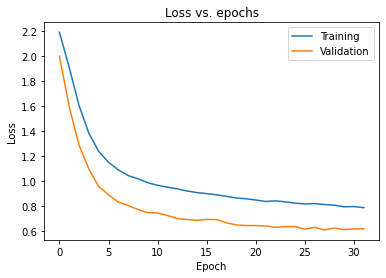

In [23]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

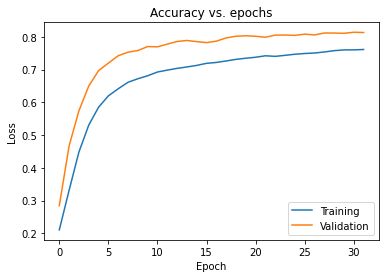

In [24]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

### Evaluations

In [25]:
model_cnn.evaluate(x_test_gs, y_test, verbose = 2)

814/814 - 1s - loss: 0.6378 - accuracy: 0.8121


[0.6377912163734436, 0.8121158480644226]

In [26]:
model_mlp.evaluate(x_test_gs, y_test, verbose = 2)

814/814 - 1s - loss: 0.8270 - accuracy: 0.7529


[0.8269519209861755, 0.7528810501098633]

### Predictions

<ipython-input-27-ad7f68ec124b>:7: DeprecationWarning: This function is deprecated. Please call randint(1, 26032 + 1) instead
  im_set = np.random.random_integers(1, y_test.shape[0], num_plts)


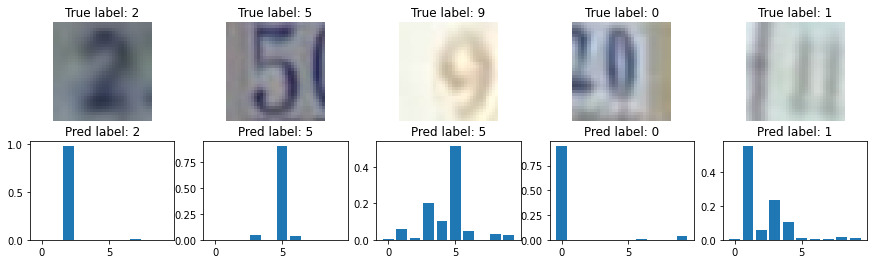

In [27]:
preds_mlp = model_mlp.predict(x_test_gs)

### Predictions from MLP
num_plts = 5

fig, ax = plt.subplots(2, num_plts, figsize=(3*num_plts, 4))
im_set = np.random.random_integers(1, y_test.shape[0], num_plts)

for i in range(len(im_set)):
    ax[0, i].imshow(x_test[:,:,:,im_set[i]])
    ax[0, i].axis('off')
    ax[0, i].set_title('True label: {0:1d}'.format(y_test[im_set[i]][0]))
    ax[1, i].bar(x = range(10), height=preds_mlp[im_set[i],:])
    ax[1, i].set_title('Pred label: {0:1d}'.format(np.argmax(preds_mlp[im_set[i],:])))

plt.show()

<ipython-input-28-1b24431bdb07>:7: DeprecationWarning: This function is deprecated. Please call randint(1, 26032 + 1) instead
  im_set = np.random.random_integers(1, y_test.shape[0], num_plts)


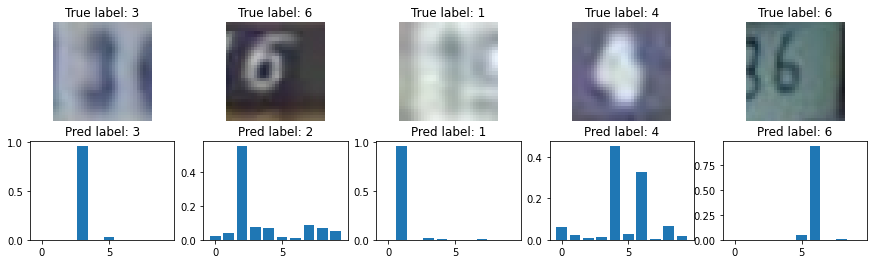

In [28]:
preds_cnn = model_cnn.predict(x_test_gs)

### Predictions from CNN
num_plts = 5

fig, ax = plt.subplots(2, num_plts, figsize=(3*num_plts, 4))
im_set = np.random.random_integers(1, y_test.shape[0], num_plts)

for i in range(len(im_set)):
    ax[0, i].imshow(x_test[:,:,:,im_set[i]])
    ax[0, i].axis('off')
    ax[0, i].set_title('True label: {0:1d}'.format(y_test[im_set[i]][0]))
    ax[1, i].bar(x = range(10), height=preds_cnn[im_set[i],:])
    ax[1, i].set_title('Pred label: {0:1d}'.format(np.argmax(preds_cnn[im_set[i],:])))

plt.show()